In [1]:
%%bash

pip install -q kaggle
mkdir -p ~/.kaggle
cp drive/MyDrive/kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d jehanbhathena/weather-dataset
unzip -qq weather-dataset.zip

100%|██████████| 587M/587M [00:29<00:00, 20.9MB/s]


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'2.11.0'

In [4]:
data_dir = pathlib.Path("dataset")
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

6862

In [5]:
img_height = 164
img_width = 164
batch_size = 32

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=437,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=437,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

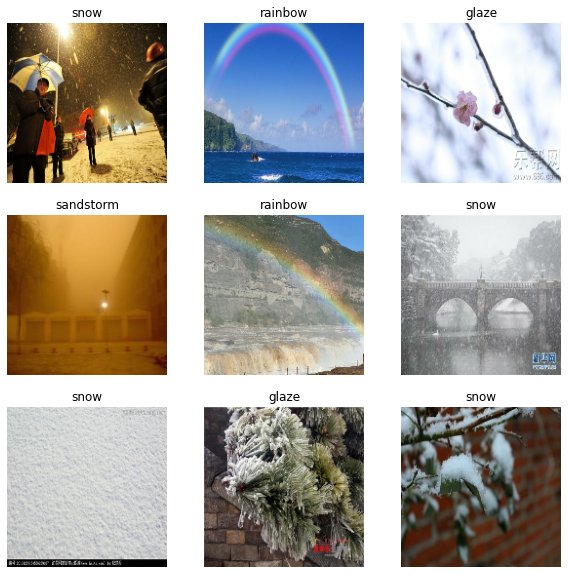

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 164, 164, 3)
(32,)


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
np.min(first_image), np.max(first_image)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(0.09453556, 1.0)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [29]:
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(164, 164, 3))
base_model.trainable = False

In [30]:
inputs = tf.keras.layers.Input(shape=(164, 164, 3))
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(11, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [31]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 164, 164, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               6554112   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 11)                5643      
                                                                 
Total params: 21,274,443
Trainable params: 6,559,755
Non-tr

In [33]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
172/172 [==============================] - 17s 97ms/step - loss: 0.6305 - accuracy: 0.8550 - val_loss: 0.9437 - val_accuracy: 0.8105
Epoch 2/10
172/172 [==============================] - 17s 101ms/step - loss: 0.5890 - accuracy: 0.8647 - val_loss: 1.0102 - val_accuracy: 0.8047
Epoch 3/10
172/172 [==============================] - 17s 101ms/step - loss: 0.5510 - accuracy: 0.8814 - val_loss: 1.1130 - val_accuracy: 0.8149
Epoch 4/10
172/172 [==============================] - 17s 98ms/step - loss: 0.6804 - accuracy: 0.8639 - val_loss: 1.0953 - val_accuracy: 0.8265
Epoch 5/10
172/172 [==============================] - 17s 98ms/step - loss: 0.7058 - accuracy: 0.8734 - val_loss: 1.5685 - val_accuracy: 0.7974
Epoch 6/10
172/172 [==============================] - 19s 109ms/step - loss: 0.5582 - accuracy: 0.8887 - val_loss: 1.1771 - val_accuracy: 0.8265
Epoch 7/10
172/172 [==============================] - 17s 99ms/step - loss: 0.6564 - accuracy: 0.8920 - val_loss: 1.3773 - val_accura

In [57]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_weather(image_loc):
  test_image = image.load_img(image_loc, target_size=(164, 164))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  test_image /= 255.0
  result = model.predict(test_image)
  result_idx = np.max(result)
  result = result.tolist()
  result = result[0].index(result_idx)
  result = class_names[result]
  plt.imshow(np.uint8(test_image[0] * 255))
  plt.title(result)
  plt.show()

--2023-02-12 18:57:07--  https://wallpapertag.com/wallpaper/full/c/3/a/810369-summer-background-pics-1920x1080-for-android-40.jpg
Resolving wallpapertag.com (wallpapertag.com)... 104.21.62.184, 172.67.138.37, 2606:4700:3031::6815:3eb8, ...
Connecting to wallpapertag.com (wallpapertag.com)|104.21.62.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344591 (337K) [image/jpeg]
Saving to: ‘810369-summer-background-pics-1920x1080-for-android-40.jpg.10’

810369-summer-backg 100%[===================>] 336.51K  --.-KB/s    in 0.006s  

2023-02-12 18:57:07 (52.4 MB/s) - ‘810369-summer-background-pics-1920x1080-for-android-40.jpg.10’ saved [344591/344591]

1/1 [==============================] - 0s 22ms/step


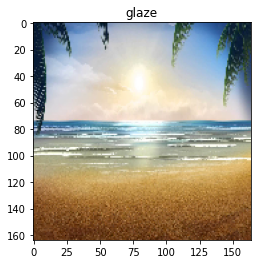

In [58]:
!wget https://wallpapertag.com/wallpaper/full/c/3/a/810369-summer-background-pics-1920x1080-for-android-40.jpg

filename_to_pred = "810369-summer-background-pics-1920x1080-for-android-40.jpg"

predict_weather(filename_to_pred)

--2023-02-12 18:58:10--  https://www.metoffice.gov.uk/binaries/content/gallery/metofficegovuk/hero-images/weather/optical-effects/rainbows/rainbow-over-the-yellowstone-landscape-in-wyoming.jpg
Resolving www.metoffice.gov.uk (www.metoffice.gov.uk)... 104.69.151.179
Connecting to www.metoffice.gov.uk (www.metoffice.gov.uk)|104.69.151.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 703584 (687K) [image/jpeg]
Saving to: ‘rainbow-over-the-yellowstone-landscape-in-wyoming.jpg’

rainbow-over-the-ye 100%[===================>] 687.09K  --.-KB/s    in 0.01s   

2023-02-12 18:58:10 (60.4 MB/s) - ‘rainbow-over-the-yellowstone-landscape-in-wyoming.jpg’ saved [703584/703584]

1/1 [==============================] - 0s 22ms/step


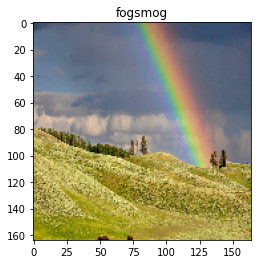

In [59]:
!wget https://www.metoffice.gov.uk/binaries/content/gallery/metofficegovuk/hero-images/weather/optical-effects/rainbows/rainbow-over-the-yellowstone-landscape-in-wyoming.jpg

filename_to_pred = "rainbow-over-the-yellowstone-landscape-in-wyoming.jpg"

predict_weather(filename_to_pred)